<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_curve, auc

from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet,ElasticNetCV
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn.svm import SVC

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [2]:
# Importing Data as pandas DataFrames
business = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('~/Desktop/DSI-SF-5/datasets/yelp_arizona_data/users_small_parsed.csv')

In [4]:
print 'businss DF shape:\n', business.shape
print
print 'business DF columns:\n', business.columns

business.head(3).T

businss DF shape:
(152832, 11)

business DF columns:
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,0,1,2
business_id,EmzaQR5hQlF0WIl24NxAZA,SiwN7f0N4bs4ZtPc4yPgiA,e5kc0CQ4R-PCCDgb274gSg
name,Sky Lounge,Palazzo,Canyon Cafe
review_count,25,19,238
city,Phoenix,Phoenix,Phoenix
stars,2.5,3,3.5
categories,"['American (New)', 'Nightlife', 'Dance Clubs',...","['Bars', 'Nightlife', 'Dance Clubs']","['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']"
latitude,33.4484,33.4559,33.4522
longitude,-112.072,-112.074,-112.069
neighborhoods,[],[],[]
variable,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey


In [5]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [6]:
business_copy.head(3).T

,0,1,2
business_id,EmzaQR5hQlF0WIl24NxAZA,SiwN7f0N4bs4ZtPc4yPgiA,e5kc0CQ4R-PCCDgb274gSg
name,Sky Lounge,Palazzo,Canyon Cafe
review_count,25,19,238
city,Phoenix,Phoenix,Phoenix
stars,2.5,3,3.5
categories,"[American (New), Nightlife, Dance Clubs, Resta...","[Bars, Nightlife, Dance Clubs]","[Cafes, Mexican, Tex-Mex, Restaurants]"
latitude,33.4484,33.4559,33.4522
longitude,-112.072,-112.074,-112.069
neighborhoods,[],[],[]
variable,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey


In [7]:
# PivotTable: Converting long format to wide
business_data = pd.pivot_table(business_copy, values='value', index=['business_id'], 
                               columns=['variable'], aggfunc=np.sum).reset_index()

In [8]:
business_data.head()

variable,business_id,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,...,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
0,--jFTZmywe7StuZ2hEjxyA,True,None,None,none,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,True
1,-0HGqwlfw3I8nkJyMHxAsQ,True,None,None,none,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,True
2,-0VK5Z1BfUHUYq4PoBYNLw,True,None,None,full_bar,True,False,False,False,False,...,None,None,None,None,None,None,None,None,None,True
3,-0bUDim5OGuv8R0Qqq6J4A,True,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,False
4,-1bOb2izeJBZjHC7NWxiPA,True,None,None,none,True,False,False,False,False,...,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True


In [20]:
# Filling None values with False
business_data.fillna(False, inplace = True)

In [21]:
# Shape of DataFrame
business_data.shape

(4132, 79)

In [22]:
chars = [' ', '/', '.', '-']

for char in chars:
    business_data.columns = [x.strip().lower().replace(char, '_') for x in business_data.columns]

In [23]:
# function to calculate hours of operation
def hours_operation(argument):
    if not argument[0]:
        return False
    else:
        store_open = int(argument[0][:2])
        store_close = int(argument[1][:2])
        if store_close < store_open:
            store_close += 24
        return store_close - store_open # if negative put 24

    
# Zip hours of operation for a given day
pref = 'hours_'
sufx_o = '_open'
sufx_c = '_close'
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']


for d in days:
    # Zip close and open hours to one column
    business_data[pref+d] = zip(business_data[pref+d+sufx_o] , business_data[pref+d+sufx_c])
    # Take difference of hours
    business_data[pref+d] = business_data[pref+d].apply(hours_operation) 
    # Replace False to zeros
    business_data[pref+d] = business_data[pref+d].replace(False, 0)
    # Drop hour open and hour close column
    business_data.drop(pref+d+sufx_o, axis=1, inplace=True)
    business_data.drop(pref+d+sufx_c, axis=1, inplace=True)

In [24]:
# Cleaning True False columns
business_data[business_data.columns[1:-7]] = business_data[business_data.columns[1:-7]].replace(['True', 'yes', 'False', 'no'], [True, True, False, False])

# Cleaning wifi col
business_data['attributes_wi_fi'].replace([False, 'paid', 'free'], [0, 1, 2], inplace=True)

# Cleaning Smoking col
business_data.attributes_smoking.replace(['outdoor'], [True], inplace=True)

# Cleaning Price Range col
business_data.attributes_price_range = business_data.attributes_price_range.astype(float)

# Clean noise level col
business_data.attributes_noise_level.replace([False, 'quiet', 'average', 'loud', 'very_loud'], [0, 0, 1, 2, 3], inplace=True)

In [25]:
business_data.shape

(4132, 72)

In [26]:
business_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 72 columns):
business_id                                    4132 non-null object
attributes_accepts_credit_cards                4132 non-null bool
attributes_accepts_insurance                   4132 non-null bool
attributes_ages_allowed                        4132 non-null object
attributes_alcohol                             4132 non-null object
attributes_ambience_casual                     4132 non-null bool
attributes_ambience_classy                     4132 non-null bool
attributes_ambience_divey                      4132 non-null bool
attributes_ambience_hipster                    4132 non-null bool
attributes_ambience_intimate                   4132 non-null bool
attributes_ambience_romantic                   4132 non-null bool
attributes_ambience_touristy                   4132 non-null bool
attributes_ambience_trendy                     4132 non-null bool
attributes_ambience_upscale  

In [27]:
business_data.head()

,business_id,attributes_accepts_credit_cards,attributes_accepts_insurance,attributes_ages_allowed,attributes_alcohol,attributes_ambience_casual,attributes_ambience_classy,attributes_ambience_divey,attributes_ambience_hipster,attributes_ambience_intimate,...,attributes_wheelchair_accessible,attributes_wi_fi,open,hours_monday,hours_tuesday,hours_wednesday,hours_thursday,hours_friday,hours_saturday,hours_sunday
0,--jFTZmywe7StuZ2hEjxyA,True,False,False,none,False,False,False,False,False,...,False,0,True,0,0,0,0,0,0,0
1,-0HGqwlfw3I8nkJyMHxAsQ,True,False,False,none,False,False,False,False,False,...,False,2,True,0,0,0,0,0,0,0
2,-0VK5Z1BfUHUYq4PoBYNLw,True,False,False,full_bar,True,False,False,False,False,...,False,0,True,0,0,0,0,0,0,0
3,-0bUDim5OGuv8R0Qqq6J4A,True,False,False,False,False,False,False,False,False,...,True,0,False,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,True,False,False,none,True,False,False,False,False,...,True,2,True,8,8,8,8,8,8,8


In [28]:
business_data.shape

(4132, 72)

In [29]:
business_copy.shape

(152832, 11)

In [30]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)
    
# Drop Categories column after extracting values
business_copy.drop('categories', axis=1, inplace=True)

business_copy.columns = [x.lower().replace(' ', '_') for x in business_copy.columns]

In [31]:
business_copy.head(3).T

,0,1,2
business_id,EmzaQR5hQlF0WIl24NxAZA,SiwN7f0N4bs4ZtPc4yPgiA,e5kc0CQ4R-PCCDgb274gSg
name,Sky Lounge,Palazzo,Canyon Cafe
review_count,25,19,238
city,Phoenix,Phoenix,Phoenix
stars,2.5,3,3.5
latitude,33.4484,33.4559,33.4522
longitude,-112.072,-112.074,-112.069
neighborhoods,[],[],[]
variable,attributes.Ambience.divey,attributes.Ambience.divey,attributes.Ambience.divey
value,False,False,False


In [32]:
# Merge business info
temp = business_copy[[u'business_id', u'name', u'city', u'review_count', u'airports', u'breakfast_&_brunch', u'bubble_tea', u'burgers', u'bars',
       u'bakeries', u'breweries', u'cafes', u'candy_stores', u'comedy_clubs',
       u'courthouses', u'dance_clubs', u'fast_food', u'museums', u'tattoo',
       u'vape_shops', u'yoga']].drop_duplicates(subset='business_id')

business_data = pd.merge(business_data, temp.drop_duplicates(subset='business_id'), 
          left_on='business_id', right_on='business_id')

In [33]:
business_data.head()

,business_id,attributes_accepts_credit_cards,attributes_accepts_insurance,attributes_ages_allowed,attributes_alcohol,attributes_ambience_casual,attributes_ambience_classy,attributes_ambience_divey,attributes_ambience_hipster,attributes_ambience_intimate,...,cafes,candy_stores,comedy_clubs,courthouses,dance_clubs,fast_food,museums,tattoo,vape_shops,yoga
0,--jFTZmywe7StuZ2hEjxyA,True,False,False,none,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,-0HGqwlfw3I8nkJyMHxAsQ,True,False,False,none,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,-0VK5Z1BfUHUYq4PoBYNLw,True,False,False,full_bar,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0bUDim5OGuv8R0Qqq6J4A,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1bOb2izeJBZjHC7NWxiPA,True,False,False,none,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [34]:
business_data.shape

(4132, 92)

** TIPS **

In [35]:
tips.columns = [x.strip().lower().replace(' ', '_') for x in tips.columns]
print tips.shape, tips.columns
tips.describe()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24_hours',
       u'amazing_food', u'animal_style', u'awesome_food', u'awesome_place',
       u'awesome_service',
       ...
       u'service_good', u'service_great', u'slow_service', u'staff_friendly',
       u'staff_great', u'steak_eggs', u'super_friendly', u'sweet_potato',
       u'velvet_pancakes', u'worth_wait'],
      dtype='object', length=104)


,likes,24_hours,amazing_food,animal_style,awesome_food,awesome_place,awesome_service,beef_hash,beer_selection,best_breakfast,...,service_good,service_great,slow_service,staff_friendly,staff_great,steak_eggs,super_friendly,sweet_potato,velvet_pancakes,worth_wait
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,...,0.002373,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,...,0.048854,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [36]:
tips.head(3)

,user_id,business_id,likes,date,24_hours,amazing_food,animal_style,awesome_food,awesome_place,awesome_service,...,service_good,service_great,slow_service,staff_friendly,staff_great,steak_eggs,super_friendly,sweet_potato,velvet_pancakes,worth_wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Dropping Date column, don't need for now
tips.drop('date', axis=1, inplace=True)

In [38]:
#Aggregating business_id by sum of tips
business_tips = tips.groupby(by='business_id', axis=0)['likes'].sum().reset_index()

In [39]:
business_tips.head()

,business_id,likes
0,--jFTZmywe7StuZ2hEjxyA,0
1,-0HGqwlfw3I8nkJyMHxAsQ,0
2,-0VK5Z1BfUHUYq4PoBYNLw,0
3,-0bUDim5OGuv8R0Qqq6J4A,0
4,-1bOb2izeJBZjHC7NWxiPA,0


In [40]:
business_tips.shape

(3752, 2)

** REVIEWS **

In [41]:
reviews.columns = [x.strip().lower().replace('.', '_') for x in reviews.columns]
reviews.columns = [x.replace(' ', '_') for x in reviews.columns]
print reviews.columns, reviews.shape
reviews.head()

Index([u'user_id', u'review_id', u'votes_cool', u'business_id', u'votes_funny',
       u'stars', u'date', u'votes_useful', u'10_minutes', u'15_minutes',
       ...
       u'service_great', u'staff_friendly', u'super_friendly', u'sweet_potato',
       u'tasted_like', u'time_vegas', u'try_place', u've_seen', u've_tried',
       u'wait_staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes_cool,business_id,votes_funny,stars,date,votes_useful,10_minutes,15_minutes,...,service_great,staff_friendly,super_friendly,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Business Review Stars
review_stars = reviews.groupby(by='business_id')['stars'].mean().reset_index()

# Round Avg rating to nearest half
review_stars.stars = review_stars.stars.apply(lambda x: round(x * 2) / 2)

review_stars.head()

,business_id,stars
0,--jFTZmywe7StuZ2hEjxyA,3.5
1,-0HGqwlfw3I8nkJyMHxAsQ,3.0
2,-0VK5Z1BfUHUYq4PoBYNLw,4.0
3,-0bUDim5OGuv8R0Qqq6J4A,2.0
4,-1bOb2izeJBZjHC7NWxiPA,4.0


In [43]:
# Different Groupbys
grouped_1 = reviews.groupby(by='business_id')[['votes_cool', 'votes_funny']].sum().reset_index()
grouped_2 = reviews.groupby(by='business_id')[reviews.columns[7:]].sum().reset_index()  

# Merge review stars with grouped_1
merge_1 = pd.merge(review_stars, grouped_1, left_on='business_id', right_on='business_id')

# Final business_review aggregate df
business_reviews = pd.merge(merge_1, grouped_2, left_on='business_id', right_on='business_id')

In [44]:
business_reviews.head()

,business_id,stars,votes_cool,votes_funny,votes_useful,10_minutes,15_minutes,20_minutes,30_minutes,bar_food,...,service_great,staff_friendly,super_friendly,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff
0,--jFTZmywe7StuZ2hEjxyA,3.5,11,7,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0HGqwlfw3I8nkJyMHxAsQ,3.0,0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-0VK5Z1BfUHUYq4PoBYNLw,4.0,2,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0bUDim5OGuv8R0Qqq6J4A,2.0,1,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,4.0,57,39,80,0,1,0,2,0,...,3,4,3,0,2,0,0,2,0,1


In [45]:
business_reviews.shape

(4132, 105)

**CHECKINS**

In [116]:
checkins.head()

,business_id,variable,value
0,SG_gEmEXL4ID6RAEinC5Bg,checkin_info.9-0,1.0
1,45puCRQ6Vh_IIAy7kkfFDQ,checkin_info.9-0,1.0
2,P7wKlbSRsoRrfH3DFOY08A,checkin_info.9-0,1.0
3,qsWxbgQwuomXvMseg23DGg,checkin_info.9-0,1.0
4,VCQ3VvnVRhibTT8J61xWkw,checkin_info.9-0,1.0


In [200]:
checkins.shape

(214299, 3)

In [115]:
checkins_copy = checkins.pivot(index='business_id', columns='variable', values='value').reset_index()

In [201]:
checkins_copy.shape

(3846, 173)

In [117]:
checkins_copy.head()

variable,business_id,checkin_info.0-0,checkin_info.0-1,checkin_info.0-2,checkin_info.0-3,checkin_info.0-4,checkin_info.0-5,checkin_info.0-6,checkin_info.1-0,checkin_info.1-1,...,checkin_info.8-4,checkin_info.8-5,checkin_info.8-6,checkin_info.9-0,checkin_info.9-1,checkin_info.9-2,checkin_info.9-3,checkin_info.9-4,checkin_info.9-5,checkin_info.9-6
0,--jFTZmywe7StuZ2hEjxyA,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
1,-0HGqwlfw3I8nkJyMHxAsQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
2,-0VK5Z1BfUHUYq4PoBYNLw,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0bUDim5OGuv8R0Qqq6J4A,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN
4,-1bOb2izeJBZjHC7NWxiPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,19.0,38.0,6.0,14.0,7.0,8.0,13.0,18.0,60.0


In [120]:
checkins_copy.fillna(0, inplace=True)

In [186]:
checkins_copy.head()

variable,business_id,checkin_info.0-0,checkin_info.0-1,checkin_info.0-2,checkin_info.0-3,checkin_info.0-4,checkin_info.0-5,checkin_info.0-6,checkin_info.1-0,checkin_info.1-1,...,checkin_info.8-4,checkin_info.8-5,checkin_info.8-6,checkin_info.9-0,checkin_info.9-1,checkin_info.9-2,checkin_info.9-3,checkin_info.9-4,checkin_info.9-5,checkin_info.9-6
0,--jFTZmywe7StuZ2hEjxyA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0HGqwlfw3I8nkJyMHxAsQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0VK5Z1BfUHUYq4PoBYNLw,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0bUDim5OGuv8R0Qqq6J4A,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1bOb2izeJBZjHC7NWxiPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,19.0,38.0,6.0,14.0,7.0,8.0,13.0,18.0,60.0


In [129]:
checkins_copy.shape

(3846, 169)

In [128]:
checkins_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Columns: 169 entries, business_id to checkin_info.9-6
dtypes: float64(168), object(1)
memory usage: 5.0+ MB


In [188]:
# Time intervals that define time of day
morning_t = (4, 11)
afternoon_t = (12, 16)
evening_t = (17, 21)
night_t = (22, 0) # Not used in for-loop

# checkin_info columns not including business_id
time_cols = checkins_copy.columns[1:]

# Creating zero column vectors for each
# time of day
morning = np.zeros(checkins_copy.shape[0])
afternoon = np.zeros(checkins_copy.shape[0])
evening = np.zeros(checkins_copy.shape[0])
night = np.zeros(checkins_copy.shape[0])

# Looping through the dataframe to sum up
# check-ins at specific time intervals
for col in time_cols:
    time_str = col.replace('-', '.').split('.')[1] # Checkin time (str)
    time_int = int(time_str) # Checkin time (int)
    if (time_int >= morning_t[0]) & (time_int <= morning_t[1]):
        morning += checkins_copy[col] 
    elif (time_int >= afternoon_t[0]) & (time_int <= afternoon_t[1]):
        afternoon += checkins_copy[col]
    elif (time_int >= evening_t[0]) & (time_int <= evening_t[1]):
        evening += checkins_copy[col]
    else:
        night += checkins_copy[col]
        
# Printing vectors to check for consitency
# Haven't assigned to df yet
print 'morning:\n', morning, len(morning)
print 'afternoon:\n', afternoon, len(afternoon)
print 'evening:\n', evening, len(evening)
print 'night:\n', night, len(night)

morning:
[ 17.  16.   0. ...,   5.  23.  27.] 3846
afternoon:
[ 50.  17.   0. ...,   1.  13.  91.] 3846
evening:
[  13.    5.   12. ...,    0.    1.  106.] 3846
night:
[  4.   0.  15. ...,   0.   0.   4.] 3846


In [190]:
# Assigning columns to df
checkins_copy['morning_checkins'] = morning
checkins_copy['afternoon_checkins'] = afternoon
checkins_copy['evening_checkins'] = evening
checkins_copy['night_checkins'] = night

In [196]:
checkins_tod = pd.concat([checkins_copy.business_id, checkins_copy[checkins_copy.columns[-4:]]], axis=1)

In [197]:
checkins_tod.head(10)

,business_id,morning_checkins,afternoon_checkins,evening_checkins,night_checkins
0,--jFTZmywe7StuZ2hEjxyA,17.0,50.0,13.0,4.0
1,-0HGqwlfw3I8nkJyMHxAsQ,16.0,17.0,5.0,0.0
2,-0VK5Z1BfUHUYq4PoBYNLw,0.0,0.0,12.0,15.0
3,-0bUDim5OGuv8R0Qqq6J4A,15.0,5.0,2.0,6.0
4,-1bOb2izeJBZjHC7NWxiPA,476.0,117.0,2.0,1.0
5,-2_O3_WKgO5In5XO5extNQ,49.0,13.0,1.0,1.0
6,-3xbryp44xhpN4BohxXDdQ,15.0,97.0,465.0,15.0
7,-4mNZfAXMd2mxEsD2YRcaQ,31.0,18.0,25.0,37.0
8,-584fn2GxYe9sLsgN2WeQA,68.0,342.0,287.0,6.0
9,-5RN56jH78MV2oquLV_G8g,31.0,42.0,575.0,86.0


** USERS **

In [46]:
users.shape

(144206, 21)

In [47]:
users.columns = [x.strip().lower().replace('.', '_') for x in users.columns]

In [48]:
# Extract years from column
users.yelping_since = users.yelping_since.apply(lambda x: int(x[:4]))

In [49]:
users.head(3).T

,0,1,2
yelping_since,2004,2004,2004
compliments_plain,959,89,2
review_count,1274,442,66
compliments_cute,206,23,2
compliments_writer,327,24,2
fans,1179,100,4
compliments_note,611,83,1
compliments_hot,1094,101,1
compliments_cool,1642,145,1
compliments_profile,116,9,NaN


In [50]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 21 columns):
yelping_since          144206 non-null int64
compliments_plain      47034 non-null float64
review_count           144206 non-null int64
compliments_cute       13133 non-null float64
compliments_writer     33222 non-null float64
fans                   144206 non-null int64
compliments_note       39872 non-null float64
compliments_hot        31748 non-null float64
compliments_cool       41069 non-null float64
compliments_profile    12368 non-null float64
average_stars          144206 non-null float64
compliments_more       25066 non-null float64
elite                  144206 non-null object
name                   144206 non-null object
user_id                144206 non-null object
votes_cool             144206 non-null int64
compliments_list       7180 non-null float64
votes_funny            144206 non-null int64
compliments_photos     18759 non-null float64
compliments_funny   

In [51]:
users.isnull().sum()

yelping_since               0
compliments_plain       97172
review_count                0
compliments_cute       131073
compliments_writer     110984
fans                        0
compliments_note       104334
compliments_hot        112458
compliments_cool       103137
compliments_profile    131838
average_stars               0
compliments_more       119140
elite                       0
name                        0
user_id                     0
votes_cool                  0
compliments_list       137026
votes_funny                 0
compliments_photos     125447
compliments_funny      113594
votes_useful                0
dtype: int64

In [52]:
users.shape

(144206, 21)

**Analysis: Predict Las Vegas**

In [53]:
# Creating X, y for model

data = business_data

# Dropping a few string columns
data.drop('attributes_ages_allowed', axis=1 , inplace=True)
data.drop('attributes_alcohol', axis=1, inplace=True)
data.drop('attributes_attire', axis=1, inplace=True)
data.drop('attributes_byob_corkage', axis=1, inplace=True)
data.drop('name', axis=1, inplace=True)


target_city = 'Las Vegas'

data['las_vegas'] = np.array(data.city == target_city)

In [54]:
# Design Matrix and Target Variable
X_cols = data.ix[:, 1:-1].drop('city', axis=1)
y_col = data.ix[:, -1]

# Convert design matrix to array
X = X_cols.values
y = y_col.values 

In [55]:
# Baseline accuracy for predicting Las Vegas
print 'Baseline Accuracy:', np.mean(y)

Baseline Accuracy: 0.621974830591


Model

Attempted a KNN model, but accuracy only hovered around 0.63

In [46]:
def accuracy_crossvalidator(X, y, knn):
    '''Inputs: X - Design Matrix
               y - labels
               knn - Classifier
       Outputs: Accuracy Scores List'''
    scores = []
    cv_indices = StratifiedKFold(y, n_folds=5)
    for train_idx, test_idx in cv_indices:
 
        X_train = X[train_idx, :]
        X_test = X[test_idx, :]

        y_train = y[train_idx]
        y_test = y[test_idx]
        
        knn.fit(X_train, y_train)
        
        acc = knn.score(X_test, y_test)
        scores.append(acc)
        
    return scores, np.mean(scores)

def get_accuracy_for_multiple_k(X, y, k_range):
    '''Function trains, tests, and scores knn for a range of k values
    Input: X - Design Matrix
           y - Labels
    Output: list of mean accuracy for each k'''
    
    accuracy_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        _, mean_acc = accuracy_crossvalidator(X, y, knn)
        accuracy_list.append(mean_acc)

    return accuracy_list

In [47]:
accuracy_list = get_accuracy_for_multiple_k(X, y, range(1,101))

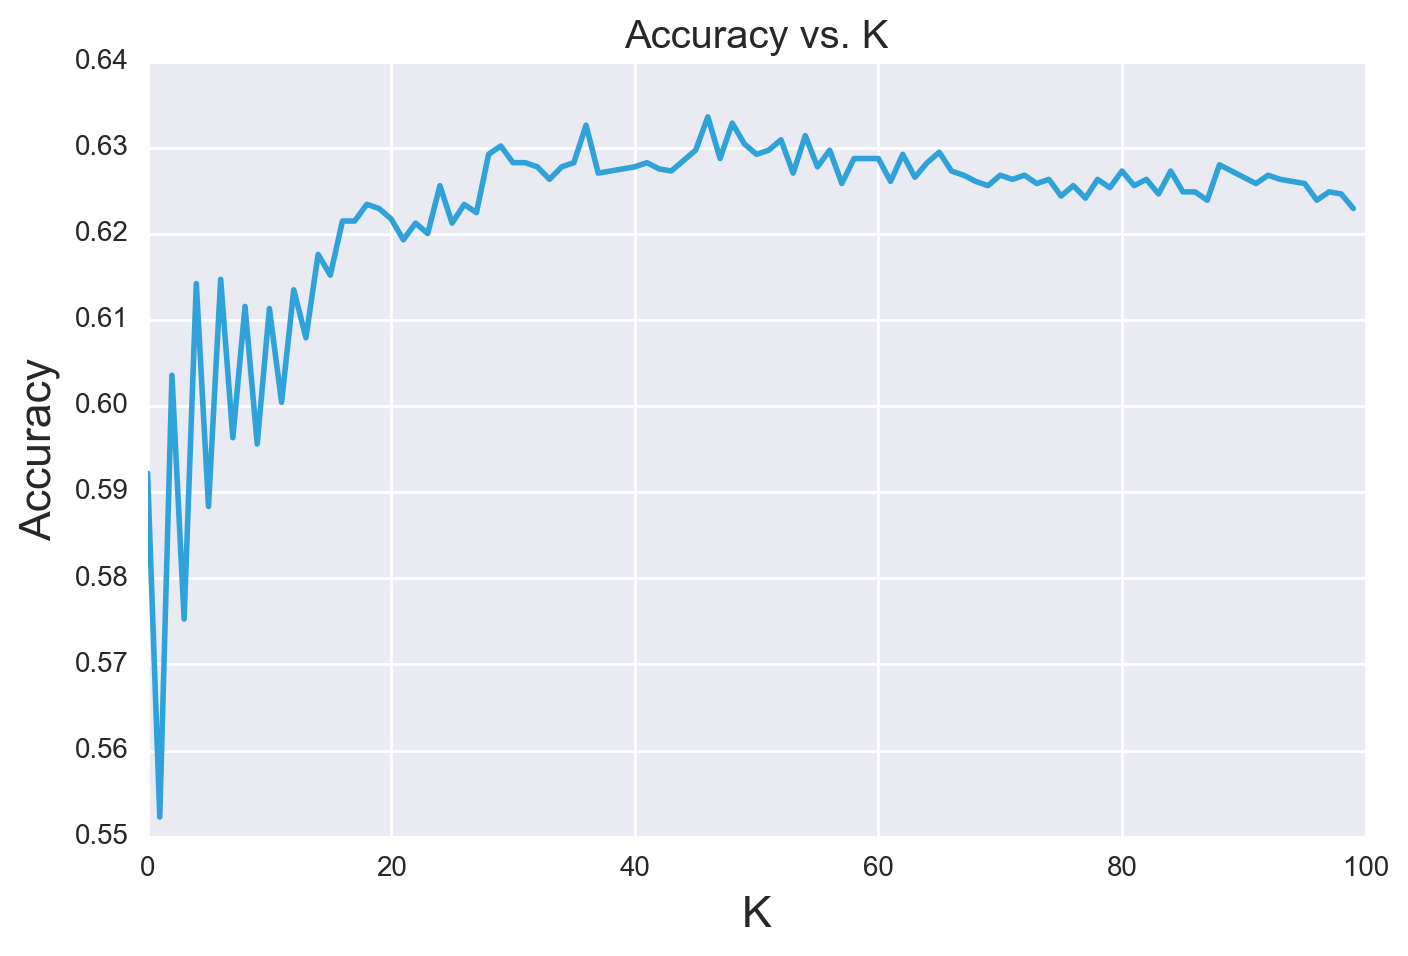

In [49]:
sns.set_style("darkgrid")
plt.figure(figsize=(7,5))
plt.title("Accuracy vs. K")
plt.plot(accuracy_list, linewidth=2.0)
plt.xlabel('K', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.show()

In [50]:
print 'KNN Model Accuracy:', round(np.max(accuracy_list), 2)

KNN Model Accuracy: 0.63


In [56]:
# Logistic Regression
ss = StandardScaler()

Xn = ss.fit_transform(X)

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [57]:
lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 50)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1, n_jobs=2)

lr_gs.fit(Xn, y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 226 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 476 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.6min finished


{'penalty': 'l1', 'C': 20.408261224489795, 'solver': 'liblinear'}


In [58]:
cv_indices = StratifiedKFold(y, n_folds=5)

lr_scores = []

for train_idx, test_idx in cv_indices:
    
    X_train, y_train = Xn[train_idx, :], y[train_idx]
    X_test, y_test = Xn[test_idx, :], y[test_idx]
    
    best_lr.fit(X_train, y_train)
    lr_scores.append(best_lr.score(X_test, y_test))

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

print 'Baseline accuracy:', np.mean(y)

Logistic Regression:
[0.66021765417170497, 0.67351874244256349, 0.68280871670702181, 0.67312348668280875, 0.67554479418886193]
0.673042678839
Baseline accuracy: 0.621974830591


In [59]:
predicted = best_lr.predict(Xn)

In [68]:
tp = np.sum((y == 1) & (predicted == 1))
fp = np.sum((y == 0) & (predicted == 1))
tn = np.sum((y == 0) & (predicted == 0))
fn = np.sum((y == 1) & (predicted == 0))

print 'True Positive:', tp
print 'True Negative:', tn
print 'False Positive:', fp
print 'False Negative:', fn
print 
print 'Total:', len(y)

True Positive: 2144
True Negative: 711
False Positive: 851
False Negative: 426

Total: 4132


In [69]:
print 'Accuracy:', accuracy_score(y, predicted)
print 'Recall:', recall_score(y, predicted)

Accuracy: 0.690948693127
Recall: 0.834241245136


In [70]:
print classification_report(y, predicted)

             precision    recall  f1-score   support

      False       0.63      0.46      0.53      1562
       True       0.72      0.83      0.77      2570

avg / total       0.68      0.69      0.68      4132



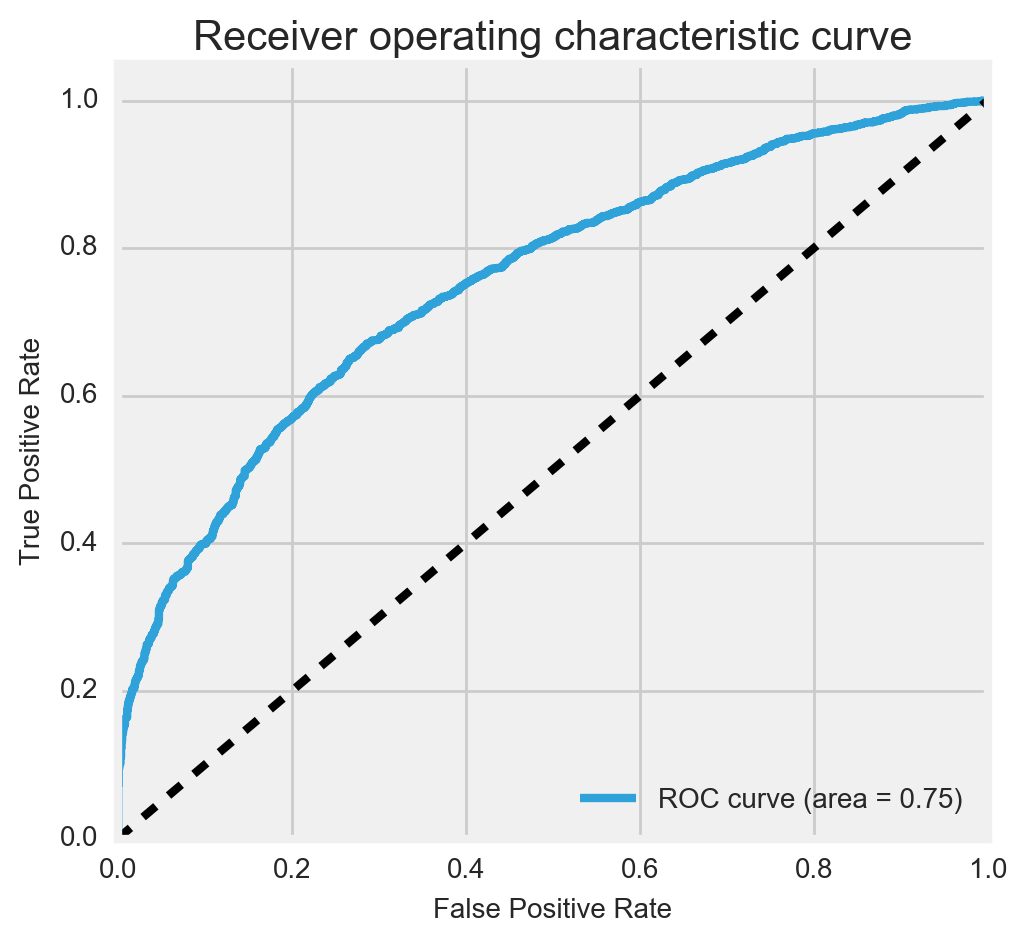

In [71]:
# Get out the predicted probabilities for the X observation matrix
y_pp = best_lr.predict_proba(Xn)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr, tpr, _ = roc_curve(y, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('Receiver operating characteristic curve', fontsize=15)
plt.legend(loc="lower right")
plt.show()



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [72]:
business_reviews.head()

,business_id,stars,votes_cool,votes_funny,votes_useful,10_minutes,15_minutes,20_minutes,30_minutes,bar_food,...,service_great,staff_friendly,super_friendly,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff
0,--jFTZmywe7StuZ2hEjxyA,3.5,11,7,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0HGqwlfw3I8nkJyMHxAsQ,3.0,0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-0VK5Z1BfUHUYq4PoBYNLw,4.0,2,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0bUDim5OGuv8R0Qqq6J4A,2.0,1,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,4.0,57,39,80,0,1,0,2,0,...,3,4,3,0,2,0,0,2,0,1


In [73]:
# Feature selection for service df
service_cols = [u'business_id', u'stars', u'votes_cool', u'votes_funny', u'votes_useful', u'10_minutes', 
                u'15_minutes', u'20_minutes', u'30_minutes', 
                u'bottle_service', u'customer_service',  u'definitely_come', u'definitely_recommend', 
                u'food_service', u'friendly_staff', u'good_service', u'great_service', u'great_experience',
                u'highly_recommend',
                u'place_good', u'place_great', u'place_just', u'really_enjoyed', u'really_good', 
                u'really_like', u'really_nice', u'recommend_place', u'service_excellent', u'service_food', 
                u'service_friendly', u'service_good', u'service_great', u'staff_friendly', u'super_friendly',
                u'wait_staff']


rev_other_cols = [u'business_id', u'stars', u'votes_cool', u'votes_funny', u'votes_useful', u'bar_food', 
                 u'beer_selection', u'best_ve', u'bloody_mary', u'chicken_waffles', u'dance_floor', 
                 u'decided_try', u'definitely_come', u'definitely_recommend', u'didn_want', u'don_know', 
                 u'don_like', u'don_think', u'don_want', u'eggs_benedict', u'fast_food', u'feel_like',
                 u'felt_like', u'fish_chips', u'food_amazing', u'food_came', u'food_delicious', u'food_good', 
                 u'food_great', u'food_just', u'french_fries', u'french_toast', u'friday_night', u'fried_chicken', 
                 u'good_food', u'good_place', u'good_thing', u'good_time', u'great_atmosphere', 
                 u'great_food', u'great_place', u'great_time', u'happy_hour', u'hash_browns', u'highly_recommend', 
                 u'hip_hop', u'ice_cream', u'just_like', u'just_ok', u'just_right', u'late_night', u'like_place', 
                 u'little_bit', u'long_time', u'looked_like', u'looks_like', u'love_place', u'mac_cheese', 
                 u'make_sure', u'mashed_potatoes', u'medium_rare', u'minutes_later', u'onion_rings', 
                 u'place_good', u'place_great', u'place_just', u'potato_fries', u'pretty_good', u'quality_food', 
                 u'really_enjoyed', u'really_good', u'really_like', 
                 u'really_nice', u'recommend_place', u'red_velvet', u'right_away', u'saturday_night', 
                 u'second_time', u'sweet_potato', u'tasted_like', u'try_place', u've_seen', u've_tried']

In [74]:
# Creating 2 dfs...one for service related cols
service_reviews = business_reviews[service_cols]
reviews_other = business_reviews[rev_other_cols]

# TENTATIVE New Rating: log(Non-Zero Mean)
service_score = np.log(service_reviews.iloc[:, 1:].sum(axis=1) / np.sum(service_reviews.iloc[:, 1:] != 0, axis=1))
other_score = np.log(reviews_other.iloc[:, 1:].sum(axis=1) / np.sum(reviews_other.iloc[:, 1:] != 0, axis=1))

# Creating New Scores Columns
business_reviews['service_score'] = service_score
business_reviews['other_score'] = other_score

business_reviews.shape

(4132, 107)

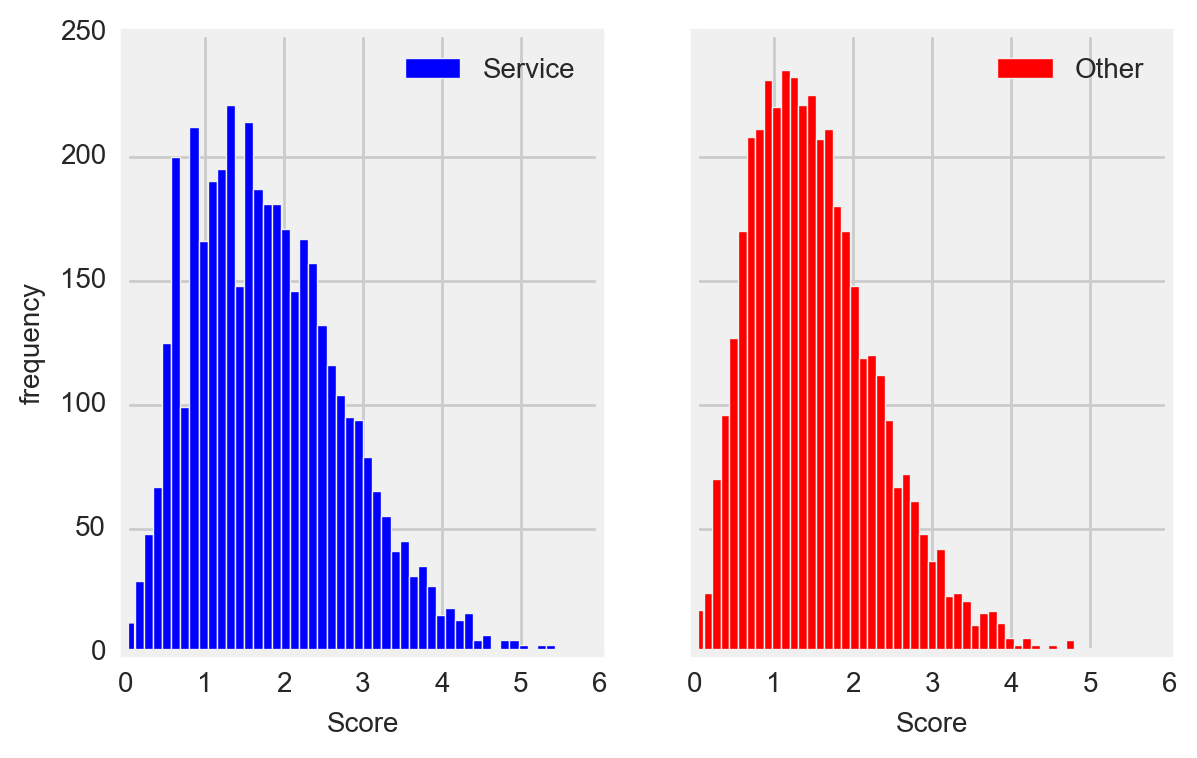

In [75]:
# Plotting distribution of scores

f, ax = plt.subplots(1, 2, sharey=True)
ax[0].hist(service_score, bins=50, color='b', label='Service')
ax[0].set_xlabel('Score', fontsize=10)
ax[0].set_ylabel('frequency', fontsize=10)
ax[0].legend()

ax[1].hist(other_score, bins=50, color='r', label='Other')
ax[1].set_xlabel('Score', fontsize=10)
ax[1].legend()

plt.show()

In [76]:
# Design Matrix
X_cols = business_reviews[business_reviews.columns[1:-2]]

# Target: Service Score
yserv_col = business_reviews[business_reviews.columns[-2:-1]]

# Target: Other Score
yoth_col = business_reviews[business_reviews.columns[-1:]]

In [77]:
# Converting to numpy arrays
X = X_cols.values
y_serv = yserv_col.values.reshape(yserv_col.shape[0])
y_oth = yoth_col.values.reshape(yoth_col.shape[0])

Regression Model: Service Score

In [78]:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [79]:
linreg = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(Xn, y_serv, test_size=0.33, random_state=4)

linreg.fit(X_train, Y_train)
linreg.score(X_test, Y_test)

0.40983586566622465

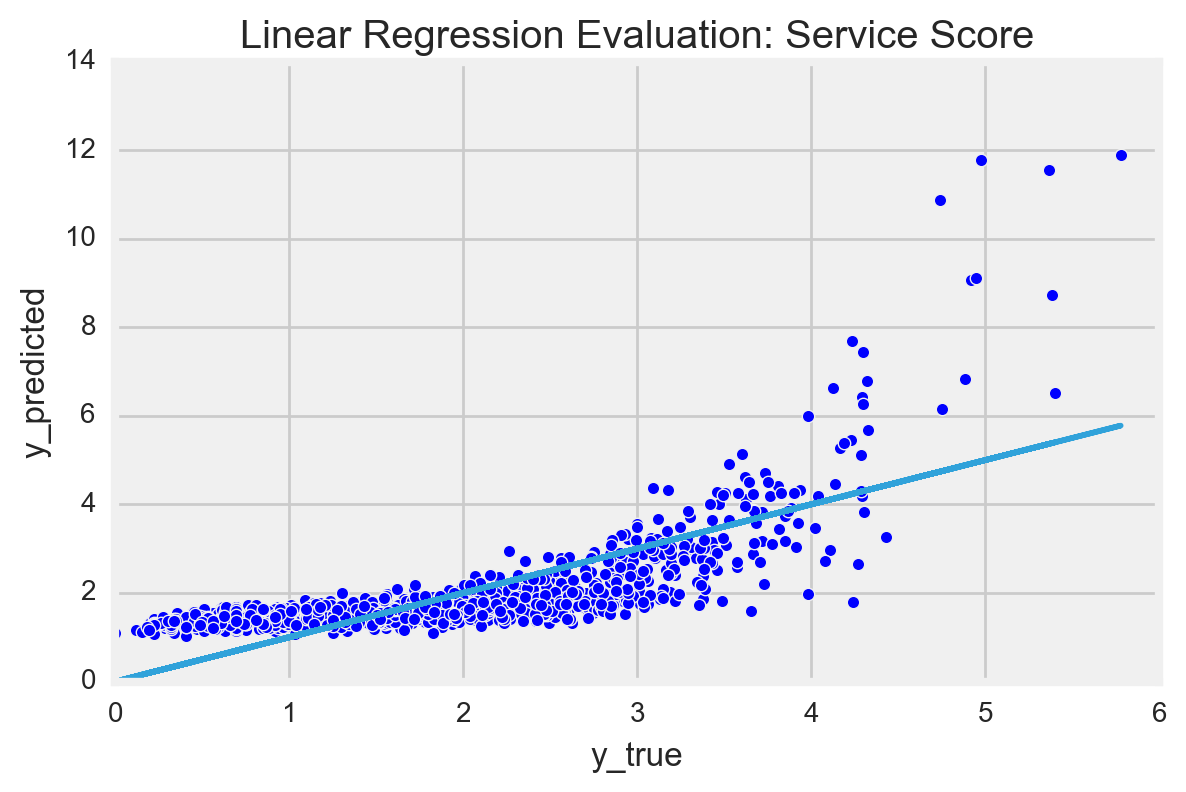

In [80]:
yhat_serv = linreg.predict(X_test)

plt.scatter(Y_test, yhat_serv)
plt.plot(Y_test, Y_test, linewidth=2.0)
plt.title('Linear Regression Evaluation: Service Score')
plt.xlabel('y_true')
plt.ylabel('y_predicted')
plt.xlim(0,6)
plt.ylim(0)
plt.show()

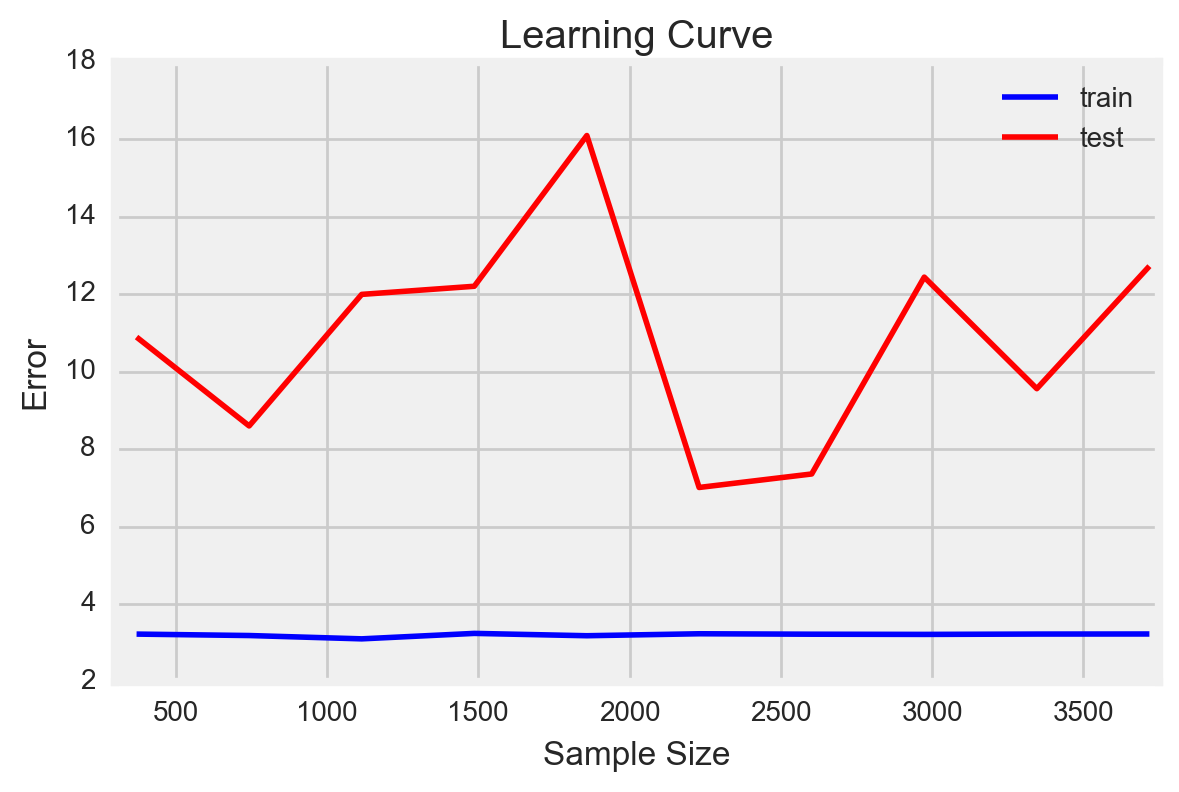

In [82]:
train_size, train_errors, test_errors = \
learning_curve(linreg,Xn, y_serv, train_sizes=np.arange(0.1, 1.1, 0.1),
               scoring = 'neg_mean_squared_error',cv=10, n_jobs=3)

train_e = -1*np.sum(train_errors, axis = 0)
test_e = -1*np.sum(test_errors, axis = 0)

plt.plot(train_size, train_e, 'b', label = 'train', linewidth=2.0);
plt.plot(train_size, test_e, 'r', label = 'test', linewidth=2.0);
plt.title('Learning Curve')
plt.xlabel('Sample Size')
plt.ylabel('Error')
plt.xlim(300, 3750)

plt.legend();

Regression Model: 'Other' Score

In [83]:
lr = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(Xn, y_oth, test_size=0.33, random_state=4)

lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

0.47790362229609018

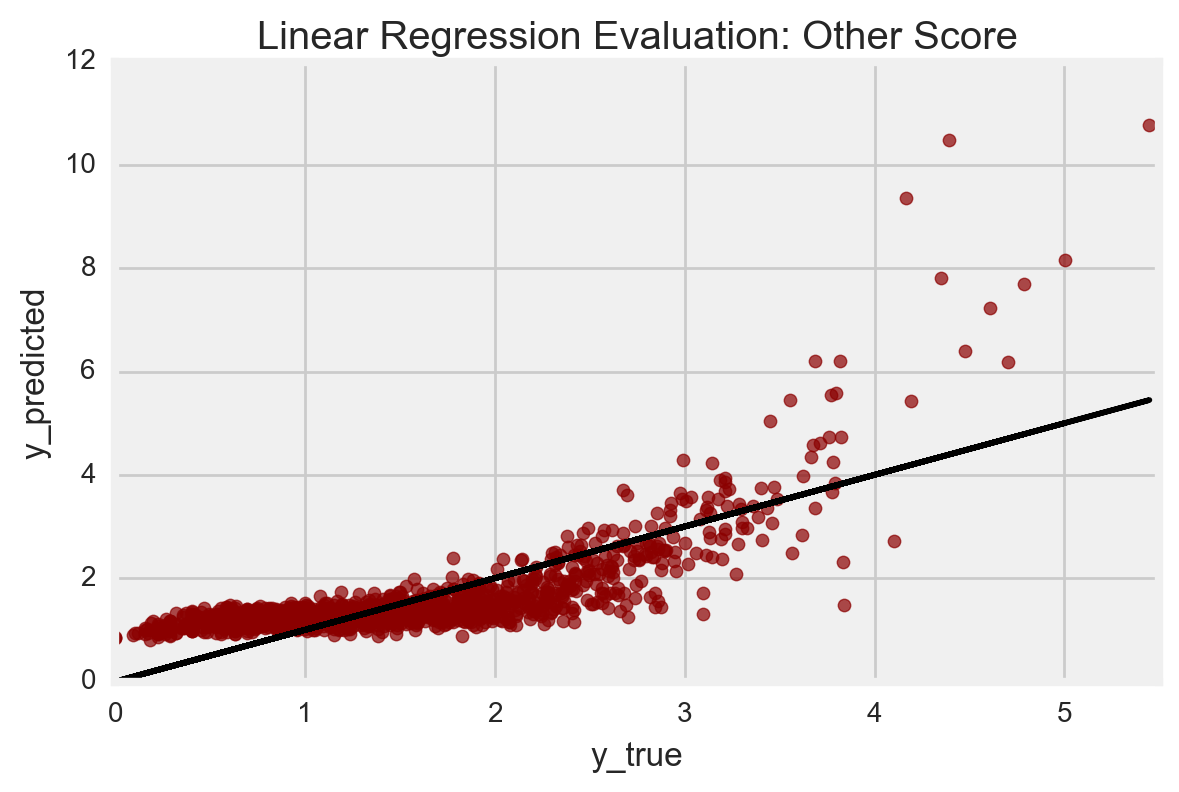

In [84]:
yhat_oth = lr.predict(X_test)

plt.scatter(Y_test, yhat_oth, color='darkred', alpha=0.7)
plt.plot(Y_test, Y_test, color='black', linewidth=2.0)
plt.title('Linear Regression Evaluation: Other Score')
plt.xlabel('y_true')
plt.ylabel('y_predicted')
plt.xlim(0,5.5)
plt.ylim(0)
plt.show()

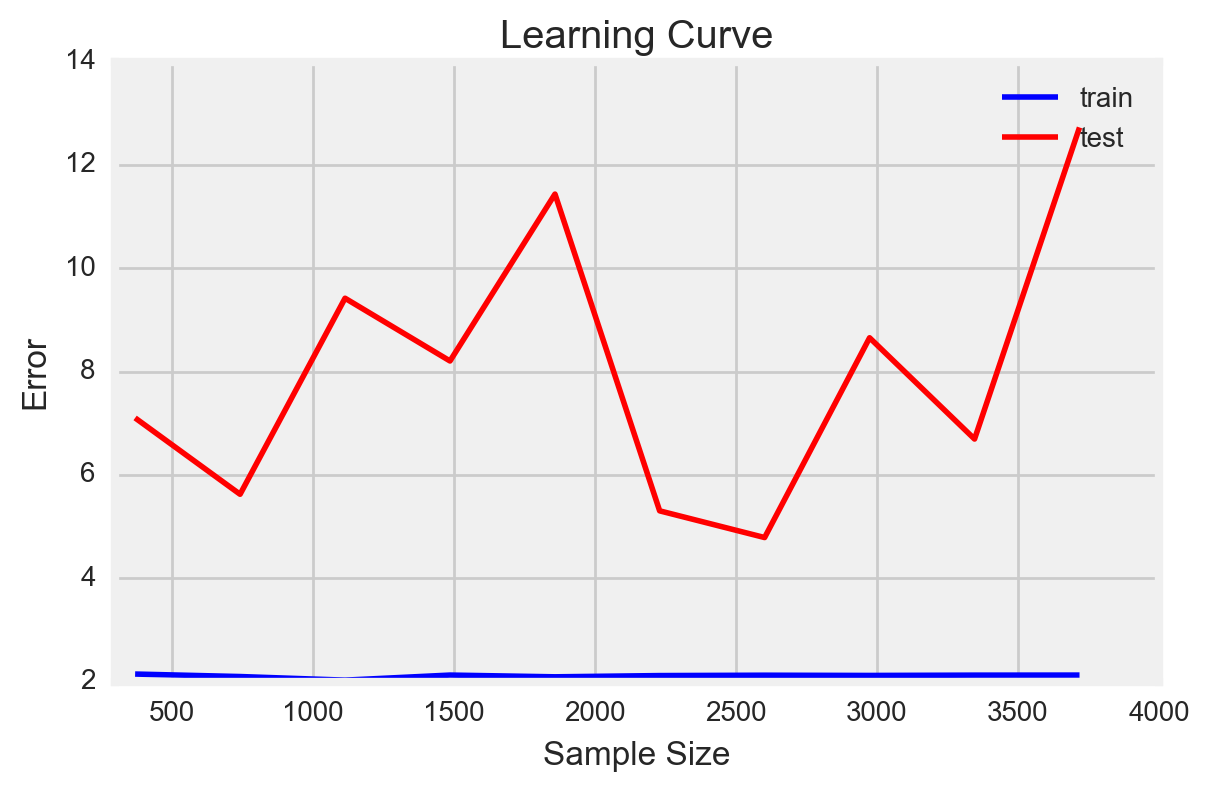

In [85]:
train_size, train_errors, test_errors = \
learning_curve(lr, Xn, y_oth, train_sizes=np.arange(0.1, 1.1, 0.1),
               scoring = 'neg_mean_squared_error',cv=10, n_jobs=3)

train_e = -1*np.sum(train_errors, axis = 0)
test_e = -1*np.sum(test_errors, axis = 0)

plt.plot(train_size, train_e, 'b', label = 'train', linewidth=2.0);
plt.plot(train_size, test_e, 'r', label = 'test', linewidth=2.0);
plt.title('Learning Curve')
plt.xlabel('Sample Size')
plt.ylabel('Error')
plt.xlim(300)

plt.legend();

Model Coefficients

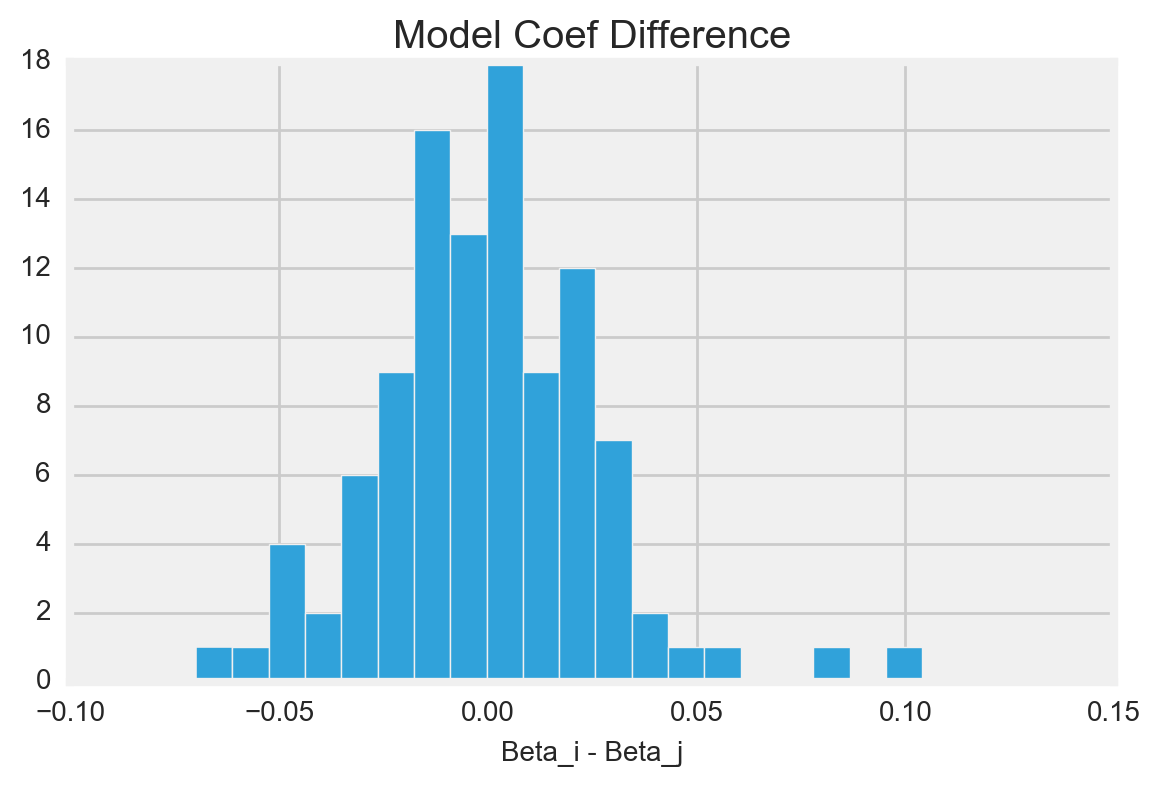

In [86]:
# Difference of model Coefs
plt.hist(linreg.coef_ - lr.coef_, bins=20)
plt.title('Model Coef Difference')
plt.xlabel('Beta_i - Beta_j', fontsize=10)
plt.show()

In [ ]:
# Instruction said create 2 new ratings
# I did this, however it meant model the ratings for service and non service
# predicting the existing ratings in 'stars'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [87]:
print 'users df shape:', users.shape
print 'reviews df shape:', reviews.shape
print 'business_review df shape:', business_reviews.shape

users df shape: (144206, 21)
reviews df shape: (322398, 108)
business_review df shape: (4132, 107)


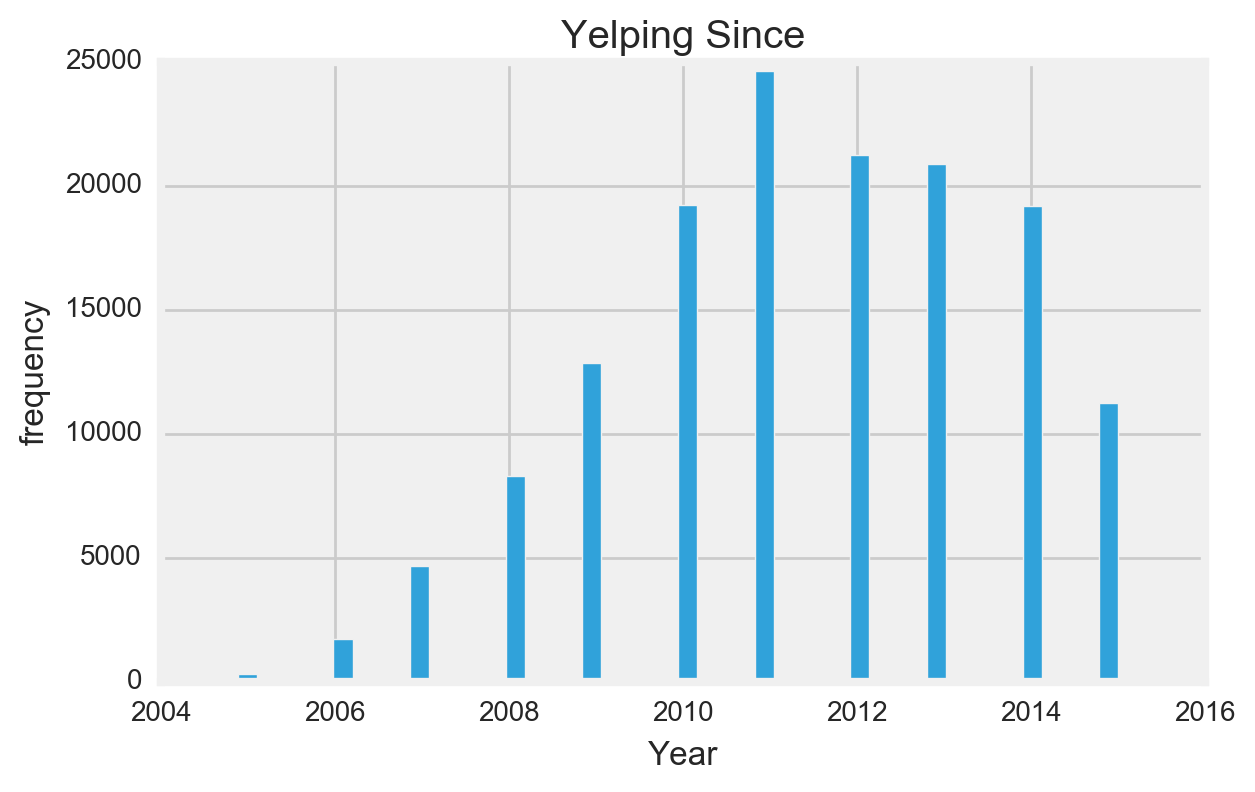

In [88]:
plt.hist(users.yelping_since, bins=50)

plt.title('Yelping Since')
plt.xlabel('Year')
plt.ylabel('frequency')
plt.show()

In [89]:
users.head(3).T

,0,1,2
yelping_since,2004,2004,2004
compliments_plain,959,89,2
review_count,1274,442,66
compliments_cute,206,23,2
compliments_writer,327,24,2
fans,1179,100,4
compliments_note,611,83,1
compliments_hot,1094,101,1
compliments_cool,1642,145,1
compliments_profile,116,9,NaN


In [90]:
users['years_yelping'] = 2015 - users.yelping_since

In [91]:
def last_elite(arg):
    '''Function to find last time user was elite'''
    return arg[1:-1].split(',')[-1].strip()

users['last_elite'] = users.elite.apply(last_elite)

In [92]:
def times_elite(arg, current_yr = 2015):
    '''Function determing number of years user was elite'''
    yr = str(current_yr)
    lst = arg[1:-1].split(', ')
    if '' in lst:
        return 0
    elif yr in lst:
        return len(lst) - 1
    else:
        return len(lst)
    
users['times_elite'] = users.elite.apply(times_elite)

In [93]:
# Bool column: User elite in 2014 or not
users['elite_2014'] = users.last_elite == '2014'

# Bool column: User elite in 2015 or not
users['elite_2015'] = users.last_elite == '2015'

In [94]:
users.head(2).T

,0,1
yelping_since,2004,2004
compliments_plain,959,89
review_count,1274,442
compliments_cute,206,23
compliments_writer,327,24
fans,1179,100
compliments_note,611,83
compliments_hot,1094,101
compliments_cool,1642,145
compliments_profile,116,9


In [95]:
test_cols = [u'user_id', u'name', u'compliments_plain', u'review_count',
       u'compliments_cute', u'compliments_writer', u'fans',
       u'compliments_note', u'compliments_hot', u'compliments_cool',
       u'compliments_profile', u'average_stars', u'compliments_more',
       u'votes_cool', u'compliments_list', u'votes_funny',
       u'compliments_photos', u'compliments_funny', u'votes_useful',
       u'years_yelping', u'times_elite', u'elite_2014', u'elite_2015']

users = users[test_cols]

In [96]:
users.shape

(144206, 23)

In [97]:
# Filling NaN values with 0
users.fillna(value=0, inplace=True)

In [98]:
# Desgin Matrix and Target
X_cols = users.columns[2:-1]
y_col = users.columns[-1]

# Numpy arrays
X = users[X_cols].values
y = users[y_col].values

In [99]:
print 'Baseline Accuracy:', np.mean(y)

Baseline Accuracy: 0.0673758373438


Classification Model for Elite Users

In [100]:
ss = StandardScaler()

Xn = ss.fit_transform(X)

In [103]:
logreg = LogisticRegression()
logreg_score = cross_val_score(logreg, Xn, y, cv=5, n_jobs=1)

In [104]:
logreg_score.mean()

0.95678407595805726

In [ ]:
# Remove count metrics and see how model changes
# If you were to remove the "counts" metrics for users (reviews, votes, compliments), 
# what distinguishes an elite user, 
# if anything? Validate the model and compare it to the one with the count variables.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

In [198]:
checkins_tod.head()

,business_id,morning_checkins,afternoon_checkins,evening_checkins,night_checkins
0,--jFTZmywe7StuZ2hEjxyA,17.0,50.0,13.0,4.0
1,-0HGqwlfw3I8nkJyMHxAsQ,16.0,17.0,5.0,0.0
2,-0VK5Z1BfUHUYq4PoBYNLw,0.0,0.0,12.0,15.0
3,-0bUDim5OGuv8R0Qqq6J4A,15.0,5.0,2.0,6.0
4,-1bOb2izeJBZjHC7NWxiPA,476.0,117.0,2.0,1.0


In [205]:
checkins_tod.shape

(3846, 5)

In [216]:
checkins_stars = pd.merge(checkins_tod, business_reviews.iloc[:, :2], left_on='business_id', right_on='business_id')

In [226]:
checkins_stars['good_rtg'] = checkins_stars.stars.map(lambda x: 1 if x >= 3.5 else 0)

In [227]:
checkins_stars.head()

,business_id,morning_checkins,afternoon_checkins,evening_checkins,night_checkins,stars,good_rtg
0,--jFTZmywe7StuZ2hEjxyA,17.0,50.0,13.0,4.0,3.5,1
1,-0HGqwlfw3I8nkJyMHxAsQ,16.0,17.0,5.0,0.0,3.0,0
2,-0VK5Z1BfUHUYq4PoBYNLw,0.0,0.0,12.0,15.0,4.0,1
3,-0bUDim5OGuv8R0Qqq6J4A,15.0,5.0,2.0,6.0,2.0,0
4,-1bOb2izeJBZjHC7NWxiPA,476.0,117.0,2.0,1.0,4.0,1


Will Explore if checkins during certain parts of the day impact stars rating.

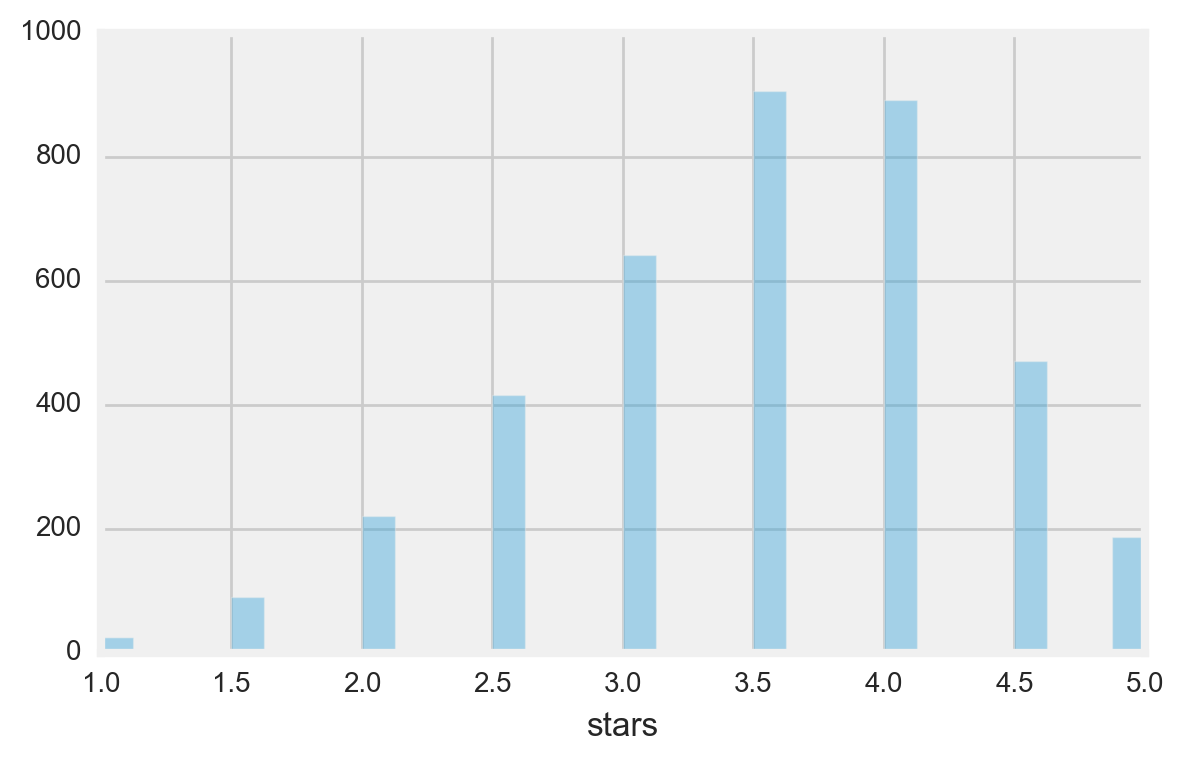

In [223]:
sns.distplot(checkins_stars.stars, kde=False);

In [234]:
print 'Baseline Accuracy:', np.mean(checkins_stars.good_rtg)

Baseline Accuracy: 0.638065522621


In [230]:
X = checkins_stars.iloc[:, 2:-2].values
y = checkins_stars.iloc[:, -1].values

In [231]:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [232]:
lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 50)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1, n_jobs=2)

lr_gs.fit(Xn, y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.7s finished


In [235]:
cv_indices = StratifiedKFold(y, n_folds=5)

lr_scores = []

for train_idx, test_idx in cv_indices:
    
    X_train, y_train = Xn[train_idx, :], y[train_idx]
    X_test, y_test = Xn[test_idx, :], y[test_idx]
    
    best_lr.fit(X_train, y_train)
    lr_scores.append(best_lr.score(X_test, y_test))

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

print 'Baseline accuracy:', np.mean(y)

Logistic Regression:
[0.63766233766233771, 0.63766233766233771, 0.63849154746423931, 0.63849154746423931, 0.63802083333333337]
0.638065720717
Baseline accuracy: 0.638065522621


In [241]:
lin_model = SVC(kernel='linear')

scores = cross_val_score(lin_model, Xn, y, cv=5)
sm = scores.mean()
ss = scores.std()
print "Average score: {:0.3} +/- {:0.3}".format(sm, ss)

Average score: 0.638 +/- 0.000372


In [269]:
rbf_model = SVC(kernel='rbf')

scores = cross_val_score(rbf_model, Xn, y, cv=5)
sm = scores.mean()
ss = scores.std()
print "Average score: {:0.3} +/- {:0.3}".format(sm, ss)

Average score: 0.638 +/- 0.000729


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 